# Student Policies
Now that you know how model cost, conversion, demand, and optimize price and matching, we can move on the final part of this game, **building your policies!**. Below we have set up skeleton code for you to build your policies. Make when you finish to run the last code cell to upload your policy.

In [2]:
# Load in all your libraries and packages here!
# NOTE: you are allowed to use packages loaded below ONLY. If you want to use any other packages, please contact the TA.
import pandas as pd
import numpy as np
import itertools
import math
import random
import copy
import time
import pandas as pd
import haversine
# from haversine import haversine
import unittest
import pickle
import collections

from utils import * # this imports all helper functions in utils.py

# TODO: Replace the string "TeamName" below with your own team's name in camel case. For e.g. "AwesomeTeam"
# DO NOT RENAME THE FILE, the file name should be "{TEAM_NAME}_Policies.py"
TEAM_NAME = "poop"

Offline Learning

In [ ]:
# Pricing parameters
A = np.load("A_matrix.npy")
b = np.load("b_vector.npy")

# Matching parameters
with open("learned_weights_model.pkl", "rb") as f:
                matching_model = pickle.load(f)
with open("matching_threshold.pkl", "rb") as f:
                threshold = pickle.load(f)


In [3]:
from sklearn.linear_model import LogisticRegression
# Load data needed for offline pricing and matching
training_data = pd.read_csv("data/training_data.csv")
area_coords = pd.read_csv("data/area_lat_lon.csv").set_index('area_id')
training_data.dropna(subset=['quoted_price', 'convert_or_not'], inplace=True)
offline_data = training_data.copy()

# offline_data = training_data.sample(frac=0.05, random_state=42).copy()

# Build base price table
base_price_table = offline_data.groupby(['pickup_area', 'dropoff_area'])['quoted_price'].median().reset_index()
base_price_table.rename(columns={'quoted_price': 'median_price'}, inplace=True)

# base_price_table = offline_data.groupby(['pickup_area', 'dropoff_area'])['quoted_price'].quantile(0.75).reset_index()
# base_price_table.rename(columns={'quoted_price': 'quantile_75_price'}, inplace=True)


conversion_rates = offline_data.groupby(['pickup_area', 'dropoff_area'])['convert_or_not'].mean().reset_index()
conversion_rates.rename(columns={'convert_or_not': 'conversion_rate'}, inplace=True)
base_price_table = base_price_table.merge(conversion_rates, on=['pickup_area', 'dropoff_area'], how='left')

base_price_table['base_price'] = base_price_table['median_price'] * (1 + 0.1 * (base_price_table['conversion_rate'] - 0.5))

# base_price_table['base_price'] = base_price_table['quantile_75_price'] * (1 + 0.1 * (base_price_table['conversion_rate'] - 0.5))



pair_counts = offline_data.groupby(['pickup_area', 'dropoff_area']).size().reset_index(name='count')
thresh = pair_counts['count'].quantile(0.9)
hot_pairs = pair_counts[pair_counts['count'] > thresh][['pickup_area', 'dropoff_area']]
base_price_table = base_price_table.merge(hot_pairs.assign(hot_pair=True), on=['pickup_area', 'dropoff_area'], how='left')
base_price_table['hot_pair'] = base_price_table['hot_pair'].fillna(False)
base_price_table.loc[base_price_table['hot_pair'], 'base_price'] *= 1.05

pickup_avg = offline_data.groupby('pickup_area')['quoted_price'].mean()
dropoff_avg = offline_data.groupby('dropoff_area')['quoted_price'].mean()
overall_avg = offline_data['quoted_price'].mean()

def marginal_boost(row):
    pickup_boost = pickup_avg.get(row['pickup_area'], overall_avg) - overall_avg
    dropoff_boost = dropoff_avg.get(row['dropoff_area'], overall_avg) - overall_avg
    return 0.05 * (pickup_boost + dropoff_boost)

base_price_table['base_price'] += base_price_table.apply(marginal_boost, axis=1)
base_price_table.set_index(['pickup_area', 'dropoff_area'], inplace=True)
base_price_table.to_csv("base_price_table.csv")

# Matching model training

def compute_match_features(rider_i, rider_j):
    oi = (rider_i['pickup_lat'], rider_i['pickup_lon'])
    di = (rider_i['dropoff_lat'], rider_i['dropoff_lon'])
    oj = (rider_j['pickup_lat'], rider_j['pickup_lon'])
    dj = (rider_j['dropoff_lat'], rider_j['dropoff_lon'])

    trip_length, shared_length, _, _, _ = populate_shared_ride_lengths(oi, di, oj, dj)
    if trip_length == 0:
        return None

    shared_efficiency = shared_length / trip_length
    detour_penalty = trip_length - (rider_i['solo_length'] + rider_j['solo_length'])
    time_diff = abs(rider_i['arrival_time'] - rider_j['arrival_time'])
    time_sync = np.exp(-time_diff / 60)

    waiting_i = getattr(rider_i, 'waiting_time', 0) or 0
    waiting_j = getattr(rider_j, 'waiting_time', 0) or 0
    avg_waiting = (waiting_i + waiting_j) / 2

    return [shared_efficiency, time_sync, avg_waiting, detour_penalty]

def generate_pairwise_training_data(df):
    pairs, labels = [], []
    riders = df.to_dict('records')
    for i in range(len(riders)):
        for j in range(i + 1, len(riders)):
            rider_i, rider_j = riders[i], riders[j]
            features = compute_match_features(rider_i, rider_j)
            if features:
                matched = int(rider_i['matching_outcome'] == rider_j['rider_id'] or rider_j['matching_outcome'] == rider_i['rider_id'])
                pairs.append(features)
                labels.append(matched)
    return np.array(pairs), np.array(labels)

# X_train, y_train = generate_pairwise_training_data(offline_data)
X_train, y_train = generate_pairwise_training_data(offline_data.sample(frac=0.05, random_state=42))

# matching_model = LogisticRegression()
# matching_model.fit(X_train, y_train)

with open("learned_weights_model.pkl", "rb") as f:
                matching_model = pickle.load(f)
train_probs = matching_model.predict_proba(X_train)[:, 1]
threshold = np.percentile(train_probs, 20)
# with open("learned_weights_model.pkl", "wb") as f:
#     pickle.dump(matching_model, f)

C:\Users\emily\AppData\Local\Temp\ipykernel_1868\3710201346.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_price_table['hot_pair'] = base_price_table['hot_pair'].fillna(False)


In [63]:
with open("matching_threshold.pkl", "wb") as f:
    pickle.dump(threshold, f)

In [4]:
# Load online pricing and matching parameters
base_price_table = pd.read_csv("base_price_table.csv").set_index(['pickup_area', 'dropoff_area'])
with open("learned_weights_model.pkl", 'rb') as f:
    matching_model = pickle.load(f)

A = np.identity(2)
b = np.zeros((2, 1))


def pair_similarity(p1, d1, p2, d2):
    dist = haversine.haversine(tuple(area_coords.loc[p1]), tuple(area_coords.loc[p2])) + \
           haversine.haversine(tuple(area_coords.loc[d1]), tuple(area_coords.loc[d2]))
    return max(0, 1 - dist / 5)

# Pricing Policy

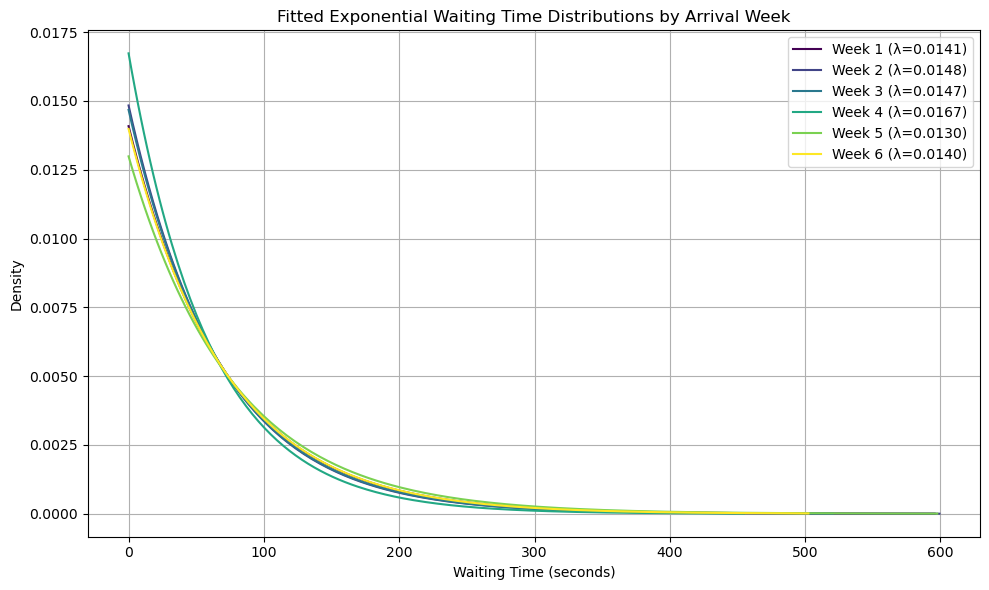

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Load and filter data
df = pd.read_csv("data/training_data.csv")
df = df[(df['convert_or_not'] == 1) & (df['matching_outcome'].isna()) & (~df['waiting_time'].isna()) & (~df['arrival_week'].isna())]


# Store lambda estimates
lambda_by_week = {}

plt.figure(figsize=(10, 6))

weeks = sorted(df['arrival_week'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(weeks)))

for i, week in enumerate(weeks):
    wait_times = df[df['arrival_week'] == week]['waiting_time']
    
    if len(wait_times) > 0:
        # Fit exponential: λ = 1 / mean
        lam = 1 / wait_times.mean()
        lambda_by_week[week] = lam

        # Generate points for the fitted curve
        x = np.linspace(0, wait_times.max(), 200)
        y = lam * np.exp(-lam * x)
        plt.plot(x, y, label=f"Week {int(week)} (λ={lam:.4f})", color=colors[i])

# Plot settings
plt.title("Fitted Exponential Waiting Time Distributions by Arrival Week")
plt.xlabel("Waiting Time (seconds)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
import pandas as pd
import numpy as np
from numpy.linalg import inv

# Load data
df = pd.read_csv("data/training_data.csv")
df = df[(df['convert_or_not'] == 1) & (df['matching_outcome'].isna()) & (~df['waiting_time'].isna())]

# Build base price table (assume already created and loaded)
base_price_table = pd.read_csv("base_price_table.csv").set_index(['pickup_area', 'dropoff_area'])

# Fit exponential waiting time distributions per week
lambda_by_week = {}
for week, group in df.groupby('arrival_week'):
    mean_wait = group['waiting_time'].mean()
    if mean_wait > 0:
        lambda_by_week[week] = 1 / mean_wait

# Initialize Thompson Sampling parameters
A = np.identity(2)
b = np.zeros((2, 1))

# Simulate state conditions and update A and b
for _, row in df.iterrows():
    pair = (row['pickup_area'], row['dropoff_area'])
    if pair in base_price_table.index:
        base_price = base_price_table.loc[pair, 'base_price']
    else:
        base_price = 0.7

    # Simulated state conditions
    pool_size = np.random.randint(0, 10)

    # Sample waiting time from exponential with λ based on arrival_week
    week = row['arrival_week']
    lam = lambda_by_week.get(week, 1/200)  # fallback λ
    avg_waiting = np.random.exponential(scale=1/lam)

    # Simulate similarity effect (can refine later)
    # Simulate current pool (choose 5 random entries)
    # sample_pool = df.sample(5)

    # Compute similarity to all other rows (exclude current)
    df_subset = df[df.index != row.name].copy()
    df_subset['similarity'] = df_subset.apply(
        lambda r: pair_similarity(row['pickup_area'], row['dropoff_area'], r['pickup_area'], r['dropoff_area']), axis=1
    )

    # Sort by similarity (descending) and arrival_time (descending), then pick top 10
    closest_recent = df_subset.sort_values(['similarity', 'arrival_time'], ascending=[False, False]).head(10)

    # Combine with the original random sample pool
    # augmented_pool = pd.concat([sample_pool, closest_recent])
    augmented_pool = closest_recent

    # Compute similarity effect
    similarity_scores = [
        pair_similarity(row['pickup_area'], row['dropoff_area'], r['pickup_area'], r['dropoff_area'])
        for _, r in augmented_pool.iterrows()
    ]
    similarity_effect = sum(1 for s in similarity_scores if s > 0.8)
    print('scores', similarity_scores)
    print('effect',similarity_effect)


    # Compute state adjustment
    state_adjustment = -0.008 * (pool_size - 3) + -0.004 * avg_waiting + -0.015 * similarity_effect
    # state_price = base_price + state_adjustment
    state_price = state_adjustment

    # Feature vector
    x = np.array([[base_price], [state_price]])
    # x = x / np.max(np.abs(x))
    # reward = row['quoted_price'] * row['solo_length'] if row['convert_or_not'] else 0
    # reward = row['quoted_price'] if row['convert_or_not'] else 0
    reward = 0.5 if row['convert_or_not'] else 0


    A += x @ x.T
    b += reward * x

# Save for runtime policy
np.save("A_matrix.npy", A)
np.save("b_vector.npy", b)


scores [0.47265018949540816, 0.47265018949540816, 0.42773543596493213, 0.42773543596493213, 0.42773543596493213, 0.40394394153515145, 0.40394394153515145, 0.20085507242894585, 0.20085507242894585, 0.20085507242894585]
effect 0
scores [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
effect 10
scores [0.022992059052945102, 0.022992059052945102, 0, 0, 0, 0, 0, 0, 0, 0]
effect 0
scores [1.0, 0.5939188957901256, 0.5912656541959447, 0.5830281494868927, 0.5459869813781391, 0.5459869813781391, 0.283956223070428, 0.283956223070428, 0.2367528549466551, 0.2270648244915282]
effect 1
scores [1.0, 1.0, 0.5218611969013267, 0.5198996974452069, 0.3594391809547115, 0.3460991700701578, 0.3460991700701578, 0.31240024698424596, 0.3066846203232927, 0.011662755234439492]
effect 2
scores [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
effect 10
scores [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5972936986232664, 0.5972936986232664]
effect 8
scores [1.0, 1.0, 0.6774868888583221, 0.6774868888583221, 0.59934

In [57]:
A = np.load("A_matrix.npy")
b = np.load("b_vector.npy")

In [63]:
A

array([[ 4.95689202e+02, -1.02446247e+05],
       [-1.02446247e+05,  2.99671410e+07]])

In [64]:
b

array([[   1271.93836042],
       [-258637.27125272]])

Feel free to add more functions to `StudentPricingPolicy` but **DO NOT** modify the initalization and static methods. Your code will only be graded based on the output of your pricing function.

In [58]:
class StudentPricingPolicy:
    # DO NOT MODIFY
    def __init__(self, c = 0.70):
        self.c = c

    # DO NOT MODIFY
    @staticmethod
    def get_name():
        return TEAM_NAME

    def pricing_function(self, state, rider):
        """
        Returns the price of the given rider in the given state

        Parameters
        ----------
        state: list
            list of rider(s) (object) waiting in the state
        rider: object
            An incoming rider

        Returns
        -------
        float
            The price of the rider: must be in [0, 1]
        """
        
        pair = (rider.pickup_area, rider.dropoff_area)
        base_price = base_price_table.loc[pair, 'base_price'] if pair in base_price_table.index else 0.7
        base_price *= 0.9


        pool_size = len(state)
        avg_waiting = np.mean([getattr(r, 'waiting_time', 0) or 0 for r in state]) if pool_size > 0 else 0
        similarity_scores = [pair_similarity(rider.pickup_area, rider.dropoff_area, r.pickup_area, r.dropoff_area) for r in state]
        similarity_effect = sum(1 for s in similarity_scores if s > 0.8)

        state_adjustment = -0.01 * (pool_size - 3) + -0.006 * avg_waiting + -0.02 * similarity_effect
        # state_price = base_price + state_adjustment
        state_price = state_adjustment

        x = np.array([[base_price], [state_price]])
        x = x / np.max(np.abs(x))
        A_inv = np.linalg.inv(A)
        theta_sample = np.random.multivariate_normal(mean=(A_inv @ b).flatten(), cov=A_inv)
        final_price = float(np.dot(theta_sample, x.flatten()))
        print('final0', final_price)
        final_price = np.clip(final_price, 0.35, 0.8)
        print('base', base_price)
        
        print('state', state_price)
        print('final', final_price)
        
        return final_price

# Matching Policy

Again, feel free to add more functions to `StudentMatchingPolicy` but **DO NOT** modify the initalization and static methods. Your code will only be graded based on the output of your matching function.

In [59]:
class StudentMatchingPolicy:
    # DO NOT MODIFY
    def __init__(self, c = 0.70):
        self.c = c

    # DO NOT MODIFY
    @staticmethod
    def get_name():
        return TEAM_NAME

    def matching_function(self, state, rider):
        """
        Returns the matched rider or None is there is no match

        Parameters
        ----------
        state: list
            list of rider(s) (object) waiting in the state
        rider: object
            An incoming rider

        Returns
        -------
        rider or None:
            Returns a matched rider (object) or None
        """
        if not hasattr(self, 'model'):
            with open("learned_weights_model.pkl", "rb") as f:
                model = pickle.load(f)
                
        if len(state) < 1:
            return None

        candidates = []
        probs = []
        for waiting_rider in state:
            features = compute_match_features(rider.__dict__, waiting_rider.__dict__)
            if features:
                prob = model.predict_proba([features])[0][1]
                if prob > threshold:
                    candidates.append((waiting_rider, prob))
                    probs.append(prob)

        if not candidates:
            return None

        if len(state) <= 5 and max(probs) <=0.5:
            return None
        else:
            best_match = max(candidates, key=lambda x: x[1])[0]
        return best_match

In [103]:
threshold

0.00012154566277857141

# Testing your Code

Use the function below to test your policies. This output will only tell you the price and matching result from your policies.

The test examples consist of 4 states and 1 incoming rider:
- Four States: These represent states with 0, 8, 35, and 77 waiting requests, respectively. Each state is created by aggregating all arriving riders within random time windows of 0 seconds, 15 seconds, 1 minute, and 2 minutes from the training data.
- Incoming Rider: This rider is randomly sampled from the training data.

In [60]:
from utils import test_policies
test_new(StudentPricingPolicy, StudentMatchingPolicy)

final0 0.7678723956390073
base 0.5552279522966644
state 0.03
final 0.7678723956390073
final0 0.7318660181594514
base 0.5552279522966644
state -0.05
final 0.7318660181594514
final0 0.7807730532561827
base 0.5552279522966644
state -0.32
final 0.7807730532561827
final0 0.6528277633437466
base 0.5552279522966644
state -0.74
final 0.6528277633437466
Match Rate: 0.250
Conversion Rate: 1.000
Cost Efficiency: -5.209
Average Quoted Price: 0.733 $/mile
Average Payment: 4.553 $/mile
Average Waiting Time: 11.97 seconds
Total Profit: 0.828 $
Average Profit per Converted Rider: 0.207 $


In [101]:
test_new(ExamplePricingPolicy,ExampleMatchingPolicy)

Match Rate: 0.250
Conversion Rate: 1.000
Cost Efficiency: -3.657
Average Quoted Price: 0.516 $/mile
Average Payment: 3.203 $/mile
Average Waiting Time: 11.97 seconds
Total Profit: -0.229 $
Average Profit per Converted Rider: -0.057 $


In [11]:
import time
import pandas as pd
import numpy as np

def test_new(PricingPolicy, MatchingPolicy):
    random.seed(42)
    np.random.seed(42)
    """
    Test Policies Function: A function that tests policies based on a student's PricingPolicy and MatchingPolicy classes.

    Parameters:
        PricingPolicy (class): A student PricingPolicy class.
        MatchingPolicy (class): A student MatchingPolicy class.
    """

    instances = pd.read_pickle('data/test_examples.pickle')
    states = instances['states']
    rider = instances['rider']

    PricingPolicyInstance = PricingPolicy()
    MatchingPolicyInstance = MatchingPolicy()

    # Metrics
    total_arrivals = 0
    converted_riders = 0
    matched_riders = 0
    total_cost = 0
    total_quoted_price = 0
    total_payment = 0
    total_waiting_time = 0

    c = PricingPolicyInstance.c

    # Simulated values for testing
    def simulate_reservation_price(solo_length):
        """Simulate rider's max willing price per mile"""
        # Example: sigmoid curve with noise
        base = 1 / (1 + np.exp(-(solo_length - 1.5)))  # sigmoid centered around 1.5 miles
        noise = np.random.normal(0, 0.05)
        return np.clip(base + noise, 0.1, 1.0)

    def simulate_waiting_time():
        """Simulate waiting time (in seconds) from exponential dist"""
        return np.random.exponential(scale=200)  # mean = 200s

    for i, state in enumerate(states):
        
        total_arrivals += 1

        price = PricingPolicyInstance.pricing_function(state, rider)
        with open("log.txt", "a") as f:
            f.write(f"Processing state {i}...\n")
            f.write(f"Pricing decision: {price:.3f}\n")

        # Display only progress in notebook
        # clear_output(wait=True)
        #print(f"Processing state {i}/{len(states)}")
        assert 0 <= price <= 1

        #print(f'\n=============== Pricing at State {i} ({len(state)} waiting requests) ===============')
        #print(f'Pricing decision: {price:.5f}')
        total_quoted_price += price

        solo_length = rider.solo_length
        reservation_price = simulate_reservation_price(solo_length)
        accepted = reservation_price >= price

        if accepted:
            converted_riders += 1
            payment = price * solo_length
            total_payment += payment
            total_cost += c

            matched_request = MatchingPolicyInstance.matching_function(state, rider)
            #print(f'\n=============== Matching at State {i} ({len(state)} waiting requests) ===============')
            if matched_request is not None:
                assert matched_request.__class__.__name__.lower() == 'rider'
                assert matched_request in state
                matched_riders += 1
                waiting_time = simulate_waiting_time()
                total_waiting_time += waiting_time
                #print('Matching decision: matched with a rider.')
            #else:
                #print('Matching decision: no match.')
        #else:
            #print('Rider rejected the price. No match attempted.')

    # Final metric computation
    throughput = converted_riders
    match_rate = matched_riders / throughput if throughput else 0
    conversion_rate = throughput / total_arrivals if total_arrivals else 0
    cost_efficiency = 1 - (total_cost / (throughput * c)) if throughput else 0
    avg_quoted_price = total_quoted_price / total_arrivals if total_arrivals else 0
    avg_payment = total_payment / throughput if throughput else 0
    avg_waiting_time = total_waiting_time / matched_riders if matched_riders else 0
    
    print('\n=============== FINAL EVALUATION METRICS ===============')
    print(f'Throughput: {throughput}')
    print(f'Match Rate: {match_rate:.3f}')
    print(f'Conversion Rate: {conversion_rate:.3f}')
    print(f'Cost Efficiency: {cost_efficiency:.3f}')
    print(f'Average Quoted Price: {avg_quoted_price:.3f} $/mile')
    print(f'Average Payment: {avg_payment:.3f} $/mile')
    print(f'Average Waiting Time: {avg_waiting_time:.2f} seconds')

In [11]:
import time
import pandas as pd
import numpy as np
import random

def test_new(PricingPolicy, MatchingPolicy):
    random.seed(42)
    np.random.seed(42)

    instances = pd.read_pickle('data/test_examples.pickle')
    states = instances['states']
    rider = instances['rider']

    PricingPolicyInstance = PricingPolicy()
    MatchingPolicyInstance = MatchingPolicy()

    total_arrivals = 0
    converted_riders = 0
    matched_riders = 0
    total_cost = 0
    total_quoted_price = 0
    total_payment = 0
    total_waiting_time = 0
    total_profit = 0
    matched_ids = set()

    c = PricingPolicyInstance.c

    def simulate_reservation_price(solo_length):
        base = 1 / (1 + np.exp(-(solo_length - 1.5)))
        noise = np.random.normal(0, 0.05)
        return np.clip(base + noise, 0.1, 1.0)

    def simulate_waiting_time():
        return np.random.exponential(scale=200)

    for i, state in enumerate(states):
        total_arrivals += 1

        price = PricingPolicyInstance.pricing_function(state, rider)
        with open("log.txt", "a") as f:
            f.write(f"Processing state {i}...\n")
            f.write(f"Pricing decision: {price:.3f}\n")

        assert 0 <= price <= 1
        total_quoted_price += price

        solo_length = rider.solo_length
        reservation_price = simulate_reservation_price(solo_length)
        accepted = reservation_price >= price

        if accepted:
            converted_riders += 1
            payment = price * solo_length
            total_payment += payment
            total_cost += c* solo_length
            matched_request = MatchingPolicyInstance.matching_function(state, rider)
            if matched_request is not None:
                if id(matched_request) not in matched_ids and id(rider) not in matched_ids:
                    matched_riders += 1
                    waiting_time = simulate_waiting_time()
                    total_waiting_time += waiting_time

                    oi = (rider.pickup_lat, rider.pickup_lon)
                    di = (rider.dropoff_lat, rider.dropoff_lon)
                    oj = (matched_request.pickup_lat, matched_request.pickup_lon)
                    dj = (matched_request.dropoff_lat, matched_request.dropoff_lon)

                    from utils import populate_shared_ride_lengths
                    trip_length, shared_length, _, _, _ = populate_shared_ride_lengths(oi, di, oj, dj)

                    cost = c * shared_length
                    total_cost -= cost

                    matched_ids.add(id(rider))
                    matched_ids.add(id(matched_request))
                # else:
                #     cost = c * solo_length
                #     total_cost += cost
                #     total_profit += (payment - cost)
        total_profit = total_payment - total_cost

    throughput = converted_riders
    match_rate = matched_riders / throughput if throughput else 0
    conversion_rate = throughput / total_arrivals if total_arrivals else 0
    cost_efficiency = 1 - (total_cost / (throughput * c)) if throughput else 0
    avg_quoted_price = total_quoted_price / total_arrivals if total_arrivals else 0
    avg_payment = total_payment / throughput if throughput else 0
    avg_waiting_time = total_waiting_time / matched_riders if matched_riders else 0
    avg_profit = total_profit / throughput if throughput else 0


    print(f'Match Rate: {match_rate:.3f}')
    print(f'Conversion Rate: {conversion_rate:.3f}')
    print(f'Cost Efficiency: {cost_efficiency:.3f}')
    print(f'Average Quoted Price: {avg_quoted_price:.3f} $/mile')
    print(f'Average Payment: {avg_payment:.3f} $/mile')
    print(f'Average Waiting Time: {avg_waiting_time:.2f} seconds')
    print(f'Total Profit: {total_profit:.3f} $')
    print(f'Average Profit per Converted Rider: {avg_profit:.3f} $')



## Congrats! You finished!

Once you have completed this notebook, you can run the following command to export your notebook to a python script. Make sure to submit only `{TEAM_NAME}_Policies.py` file. Please do not edit anything!

In [5]:
# DO NOT MODIFY
from utils import export_notebook
# export the notebook as a .py file with name of "{TEAM_NAME}_Policies.py"
export_notebook(TEAM_NAME)

[NbConvertApp] Converting notebook student_policies.ipynb to script


Converted student_policies.ipynb to TeamName_Policies.py successfully, and removed print statements!


[NbConvertApp] Writing 3784 bytes to student_policies.py
